<a href="https://colab.research.google.com/github/subhambgh/generativeModels/blob/main/VAE_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

bs = 100
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [ ]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, h_dim3, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc3 = nn.Linear(h_dim2, h_dim3)
        self.fc41 = nn.Linear(h_dim3, z_dim)
        self.fc42 = nn.Linear(h_dim3, z_dim)
        # decoder part
        self.fc5 = nn.Linear(z_dim, h_dim3)
        self.fc6 = nn.Linear(h_dim3, h_dim2)
        self.fc7 = nn.Linear(h_dim2, h_dim1)
        self.fc8 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        h = F.relu(self.fc3(h))
        return self.fc41(h), self.fc42(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc5(z))
        h = F.relu(self.fc6(h))
        h = F.relu(self.fc7(h))
        return F.sigmoid(self.fc8(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

# build model
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, h_dim3=128, z_dim=2)
if torch.cuda.is_available():
    vae.cuda()

In [ ]:
vae

VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc41): Linear(in_features=128, out_features=2, bias=True)
  (fc42): Linear(in_features=128, out_features=2, bias=True)
  (fc5): Linear(in_features=2, out_features=128, bias=True)
  (fc6): Linear(in_features=128, out_features=256, bias=True)
  (fc7): Linear(in_features=256, out_features=512, bias=True)
  (fc8): Linear(in_features=512, out_features=784, bias=True)
)

In [ ]:
optimizer = optim.Adam(vae.parameters())
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [ ]:
losses = []
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.cuda()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        losses.append(loss.item()/ len(data))
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [ ]:
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.cuda()
            recon, mu, log_var = vae(data)
            
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [ ]:
for epoch in range(1, 51):
    train(epoch)
    test()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [0/60000 (0%)]	Loss: 543.396562
Train Epoch: 1 [10000/60000 (17%)]	Loss: 207.922773
Train Epoch: 1 [20000/60000 (33%)]	Loss: 195.425254
Train Epoch: 1 [30000/60000 (50%)]	Loss: 182.722363
Train Epoch: 1 [40000/60000 (67%)]	Loss: 166.559395
Train Epoch: 1 [50000/60000 (83%)]	Loss: 173.117988
====> Epoch: 1 Average loss: 188.0725
====> Test set loss: 163.9732
Train Epoch: 2 [0/60000 (0%)]	Loss: 169.411816
Train Epoch: 2 [10000/60000 (17%)]	Loss: 167.537734
Train Epoch: 2 [20000/60000 (33%)]	Loss: 159.022354
Train Epoch: 2 [30000/60000 (50%)]	Loss: 165.994512
Train Epoch: 2 [40000/60000 (67%)]	Loss: 157.858965
Train Epoch: 2 [50000/60000 (83%)]	Loss: 156.470234
====> Epoch: 2 Average loss: 158.8203
====> Test set loss: 155.2416
Train Epoch: 3 [0/60000 (0%)]	Loss: 149.123535
Train Epoch: 3 [10000/60000 (17%)]	Loss: 157.690615
Train Epoch: 3 [20000/60000 (33%)]	Loss: 151.363281
Train Epoch: 3 [30000/60000 (50%)]	Loss: 159.839990
Train Epoch: 3 [40000/60000 (67%)]	Loss: 153.74

In [ ]:
with torch.no_grad():
    z = torch.randn(64, 2).cuda()
    sample = vae.decoder(z).cuda()
    save_image(sample.view(64, 1, 28, 28), './sample_' + '.png')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


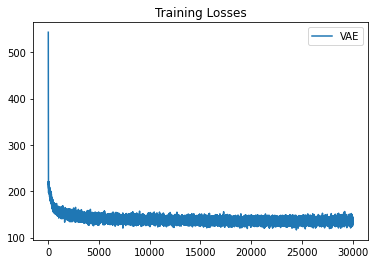

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses, label='VAE')
plt.title("Training Losses")
plt.legend()